In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa 
import numpy as np
import torch; from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import math
from torch.utils.data.dataset import random_split as split 
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from tqdm import trange
MIN_SAMPLES = True
PATH_ANNOTATIONS = 'Wingbeats/min_annotations.txt' if MIN_SAMPLES else 'Wingbeats/annotations.txt'
n_classes = 6
lr = 1e-4
n_epochs = 50
batch_size = 32

In [56]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [57]:
class AudioToSpectrogramTransform:
    def __init__(self, sample_rate=22050, n_mels=128, n_fft=1024, hop_length=512, 
                 target_height=128, target_width=64): 
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_height = target_height
        self.target_width = target_width
        
        self.mel_spectrogram = T.Spectrogram(n_fft=n_fft)
        self.amplitude_to_db = T.AmplitudeToDB()
    
    def __call__(self, waveform):
        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)
        return mel_spec_db#self._resize_rectangular(mel_spec_db)
    
    def _resize_rectangular(self, spec):
        C, H, W = spec.shape
        
        # Interpolación a tamaño rectangular
        spec_resized = nn.functional.interpolate(
            spec.unsqueeze(0),
            size=(self.target_height, self.target_width),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)
        
        spec_resized = (spec_resized - spec_resized.min()) / (spec_resized.max() - spec_resized.min() + 1e-8)
        spec_resized = spec_resized.repeat(3, 1, 1)
        
        return spec_resized  # [3, 128, 64]

In [ ]:
class AudioDatasetFromTxt(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        audio_path = self.dataframe.iloc[index]['file_path']
        label = self.dataframe.iloc[index]['label']
        
        waveform, _ = librosa.load(audio_path)
        
        waveform = torch.from_numpy(waveform).float().unsqueeze(0)
        
        if self.transform:
            spectrogram = self.transform(waveform)
            return spectrogram, label
        else:
            return waveform, label

In [59]:
def dividirDatos(archivoAnnotaciones, test_size=0.2, random_state=42):
    df = pd.read_csv(archivoAnnotaciones)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    print('Total = ', len(df))
    print('Total train = ', len(train_df))
    print('Total test = ', len(test_df))
    return train_df, test_df

In [60]:
train_df, test_df = dividirDatos(PATH_ANNOTATIONS)
# Definir transformaciones
train_transform = AudioToSpectrogramTransform(
    sample_rate=22050,
    n_mels=128,
    n_fft=1024,
    hop_length=512,
    target_height=128,
    target_width=128
)

# Para test, puedes usar la misma transformación pero sin data augmentation
test_transform = AudioToSpectrogramTransform(
    sample_rate=22050,
    n_mels=128,
    n_fft=1024,
    hop_length=512,
    target_height=128,
    target_width=128
)

# Crear datasets
train_dataset = AudioDatasetFromTxt(
    train_df, 
    sr=22050, 
    transform=train_transform
)

test_dataset = AudioDatasetFromTxt(
    test_df, 
    sr=22050, 
    transform=test_transform
)

Total =  115782
Total train =  92625
Total test =  23157


In [61]:
n_train = int(len(train_dataset) * 0.9)
n_val = math.ceil(len(train_dataset) * 0.1)
train_dataset, val_dataset = split(train_dataset, [n_train, n_val], 
                                   generator=torch.manual_seed(42))
# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valDataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(n_train, n_val)

83362 9263


torch.Size([1, 513, 22])
tensor([3, 4, 4, 4, 2, 4, 0, 1, 1, 0, 3, 4, 4, 1, 2, 4, 3, 1, 0, 5, 2, 1, 5, 4,
        3, 4, 2, 0, 1, 2, 3, 5])
(513, 22, 1)


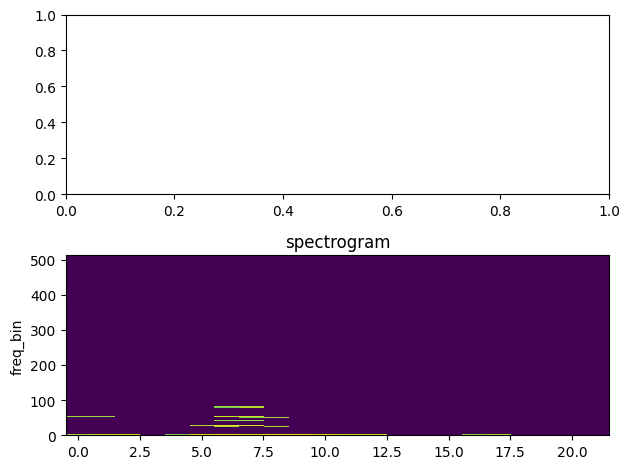

In [62]:
for data, label in train_loader:
    print(data[3].shape)
    print(label)
    spectrogram_np = data.detach().cpu().numpy()[0]
    spectrogram_np = np.transpose(spectrogram_np, (1,2,0))
    if spectrogram_np.max() <= 1.0:
        spectrogram_np = (spectrogram_np * 255).astype(np.uint8)
    print(spectrogram_np.shape)
    fig, axs = plt.subplots(2, 1)
    plot_spectrogram(spectrogram_np, title="spectrogram", ax=axs[1])
    fig.tight_layout()
    break

In [63]:
class AudioNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=2),
            nn.LeakyReLU(0.01),
            nn.Conv1d(32, 64, kernel_size=3, stride=2),
            nn.LeakyReLU(0.01),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, n_classes)
    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(-1)
        return self.fc(x)

#s_p_e = math.ceil(n_train/batch_size)
#model = AudioNet().cuda()
#criterion = nn.CrossEntropyLoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
#                                    steps_per_epoch=s_p_e, epochs=n_epochs, pct_start=0.4)
#s_p_e

In [64]:
def training(my_dataloader):
    total_loss = 0.0; n_correct = 0.0
    n_samples = len(my_dataloader.dataset)
    model.train()
    for i, (data, labels) in enumerate(my_dataloader):
        labels = labels.cuda(non_blocking=True)
        outputs = model(data.cuda(non_blocking=True))
        predictions = torch.argmax(outputs, dim=1)
        n_correct += torch.sum(labels == predictions).item()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return total_loss / n_samples, 100 * n_correct / n_samples

In [65]:
def evaluation(my_dataloader):
    n_samples = len(my_dataloader.dataset)
    with torch.no_grad():
        total_loss = 0.0; n_correct = 0
        model.eval()
        for i, (data, labels) in enumerate(my_dataloader):
            labels = labels.cuda(non_blocking=True)
            outputs = model(data.cuda(non_blocking=True))
            predictions = torch.argmax(outputs, dim=1)
            n_correct += torch.sum(predictions == labels).item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / n_samples, 100 * n_correct/ n_samples


In [66]:
def fitting(epochs):
    df = pd.DataFrame(
        np.empty([epochs, 5]), 
        index=np.arange(epochs),
        columns=['loss_train', 'acc_train', 'loss_val', 'acc_val', 'lr']
    )
    progress_bar = trange(epochs)
    for i in progress_bar:
        df.iloc[i, 0], df.iloc[i, 1] = training(trainDataloader)
        df.iloc[i, 2], df.iloc[i, 3] = evaluation(valDataloader)
        df.iloc[i, 4] = optimizer.param_groups[0]['lr']
        progress_bar.set_description("train_loss=%.5f" % df.iloc[i, 0])
        progress_bar.set_postfix(
            {'train_acc':df.iloc[i,1], 'test_acc':df.iloc[i, 3]}
        )
    return df

#train_history = fitting(n_epochs)